# Employing Custom System Models on EdgeSimPy Simulations

EdgeSimPy ships several built-in system models representing user mobility ([Pathway](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/mobility_models/pathway.py), [Random](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/mobility_models/random_mobility.py)), user access patterns ([Circular](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/user_access_patterns/circular_duration_and_interval_access_pattern.py), [Random](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/user_access_patterns/random_duration_and_interval_access_pattern.py)), and power consumption of servers ([Linear](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/power_models/servers/linear_server_power_model.py), [Square](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/power_models/servers/square_server_power_model.py), and [Cubic](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/power_models/servers/cubic_server_power_model.py)) and network switches ([Conterato et al.](https://github.com/EdgeSimPy/EdgeSimPy/blob/master/edge_sim_py/components/power_models/network/conterato_network_power_model.py)). In addition, EdgeSimPy's decoupled architecture facilitates the incorporation of custom system models to represent other behaviors.

This notebook will show how to use custom mobility and power consumption models on EdgeSimPy simulations. For this, we will go through the following steps:
1. Creating a sample dataset that specifies the behavior of a couple of components that employ built-in and custom mobility and power consumption models.
2. Simulating the scenario described in the created dataset, passing the custom models as parameters to EdgeSimPy's Simulator class.
3. Analyzing EdgeSimPy's simulation logs (emphasis on user mobility and edge server power consumption).


<blockquote>

<strong>⚠️ COMPATIBILITY WARNING ⚠️</strong>

Be aware that this notebook will only work with EdgeSimPy v1.1.0 and newer versions.

</blockquote>

## Loading Dependencies

Before we start our journey toward employing custom system models in EdgeSimPy, let's load the dependencies. The cell below (optionally) downloads and imports the following libraries:
1. EdgeSimPy (Simulation)
2. Matplotlib (Interactive Visualization)
3. Pandas (Log Parsing)

In addition, it imports some of Python's built-in modules (`os` and `random`) to enable the reproducibility of our notebook results and for reading EdgeSimPy's log files.

In [1]:
try:
    # Importing EdgeSimPy components and its built-in libraries (NetworkX and MessagePack)
    from edge_sim_py import *
    import networkx as nx
    import msgpack

    # Importing Matplotlib, Pandas, and NumPy for logs parsing and visualization
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

except ModuleNotFoundError:
    # Downloading EdgeSimPy binaries from GitHub (the "-q" parameter suppresses Pip's output. You check the full logs by removing it)
    %pip install -q git+https://github.com/EdgeSimPy/EdgeSimPy.git

    # Downloading Pandas, NumPy, and Matplotlib
    %pip install -q pandas==2.2.2
    %pip install -q numpy==1.26.4
    %pip install -q matplotlib==3.8.0

    # Importing EdgeSimPy components and its built-in libraries (NetworkX and MessagePack)
    from edge_sim_py import *
    import networkx as nx
    import msgpack

    # Importing Matplotlib, Pandas, and NumPy for logs parsing and visualization
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

# Importing Python's built-in modules
import random
import os

Now, let's define a seed value to ensure that our notebook generates reproducible outcomes regardless of any stochastic behavior called during the process.

In [2]:
# Defining a seed value to enable reproducible outcomes
random.seed(1)

## Creating the Dataset

For most EdgeSimPy simulations, the most fundamental component in the dataset relates to the map model, which encapsulates the coordinates system employed by several simulation entities such as base stations, edge servers, and users. Although the map model typically has no impact on some system models (e.g., power consumption models), being aware of it is especially important when considering using custom mobility models. For example, it is pointless to import realistic user mobility traces without planning how to embed all the involved coordinates in the base stations since the default mobility behavior in EdgeSimPy implicates the transit of users between coordinates linked to different base stations (which serve as network entry points for the users).

EdgeSimPy's default architecture uses a map model proposed by Aral et al., which divides the map into hexagonal cells. Although this model is usually hard to convert to realistic, fine-grained coordinates, it facilitates the geospatial representation of large-scale scenarios, having been adopted by several works in telecommunications.

We can create a hexagonal cell calling EdgeSimPy's `hexagonal_grid` function, which automatically generates the set of coordinates for a given map size (X and Y). The `hexagonal_grid` returns a Python list with a bunch of small 2-item lists (each of these 2-item lists represents one of the coordinates).

In [3]:
map_coordinates = hexagonal_grid(x_size=3, y_size=3)

Once we have our coordinates set, we can use them to create our base stations. As EdgeSimPy's default hexagonal map model assumes the presence of a base station at each coordinate, in addition to serving as network entry points for users on the map, other components (e.g., edge servers and network switches) will also be connected to the base stations. Imagine a scenario like the one depicted in the Figure below, where each hexagonal cell represents a region in the map with a coordinate assigned to it.

Each hexagonal cell necessarily has a base station (otherwise, users in that cell would not be able to access the edge network) and a network switch (as we want all base stations to be connected, forming a wired network infrastructure). In addition, base stations may optionally be equipped with edge servers for hosting services.

The Figure below represents a scenario comprised of six hexagonal cells (i.e., with six base stations and six network switches), nine network links (denoted as L1–L9), and three edge servers (ES1–ES3). We also have two users accessing an application each. Whereas User 1 accesses an application composed of a single service (S1), User 2 accesses an application composed of two services (S2 and S3). Please notice that the network communication between users and their applications (denoted as dotted arrows above the network links) depends on their positions and the adopted service placement.


<img src="https://raw.githubusercontent.com/EdgeSimPy/edgesimpy-tutorials/master/assets/1675091491_edgesimpy_scenario.png" alt="EdgeSimPy's default map model" style="width:500px;"/>

Be aware that we will not be creating the exact scenario depicted in the image above—a further explanation on the dataset we're creating will be given in the following cells.

That being said, let's create a base station and a network switch for each coordinate in the map:

In [4]:
for coordinates in map_coordinates:
    # Creating the base station object
    base_station = BaseStation()
    base_station.wireless_delay = 0
    base_station.coordinates = coordinates

    # Creating network switch object using the "sample_switch()" generator
    network_switch = sample_switch()
    base_station._connect_to_network_switch(network_switch=network_switch)

Although we have a network switch for each base station on the map, there have yet to be network links connecting them. EdgeSimPy enables any wired network topology by leveraging the features of the [NetworkX](https://networkx.org/) library. Although we can manually create a network topology using NetworkX, EdgeSimPy provides some helper methods that automatically do that for us.

Let us create a mesh topology connecting the network switches. As edge networks might be comprised of links with heterogeneous specifications, EdgeSimPy's network builder helpers have a `link_specifications` attribute, which expects a list of dictionaries, where each dictionary represents a link specification with three keys:
1. `"number_of_objects"`: number of network links in the network topology that will employ the specification.
2. `"delay"`: delay of the network links.
3. `"bandwidth"`: bandwidth of the network links.

Please notice that the `"number_of_objects"` keys of the link specifications do not dictate the number of links within the network topology (this is defined automatically within the helper method's internal behavior). Instead, `"number_of_objects"` describes how many of the created links will ship its specification. As we might not have a priori knowledge of the number of links that the helper will generate, we might define a random number (e.g., 1) for each configuration, which will lead to an error whose message will tell us the correct number of links, allowing us to edit the specifications with the expected value. In this case, the `"number_of_objects"` was already defined with the correct value based on the number of network switches.

In [5]:
partially_connected_hexagonal_mesh(
    network_nodes=NetworkSwitch.all(),
    link_specifications=[
        {"number_of_objects": 16, "delay": 1, "bandwidth": 10},
    ],
)

Topology_1

### Creating Edge Servers

Now that we have defined the network switches and base stations, it's time to create some edge servers. As one of the goals of this tutorial is to demonstrate the integration of custom power consumption models, we will create two edge servers: one using the `LinearPowerModel` (one of EdgeSimPy's built-in power consumption models) and one using a custom power consumption model.

EdgeSimPy implements Power models as classes with a class method called `get_power_consumption(cls, device)`, which returns the power consumption of a given device passed as an argument to it. Please notice that the only attribute that matters to us is `device`, as `cls` is a mandatory attribute for Python's class methods. One of the cells below will demonstrate how we can create a custom power consumption model class.

Edge servers in EdgeSimPy have two particularly interesting attributes for supporting power consumption models. The first, called `power_model`, points to the edge server's power model class. The second, called `power_model_parameters`, is a dictionary containing any parameter used by the power model to calculate the edge server's power consumption.

#### Edge Server 1 — Using EdgeSimPy's Built-In Power Models

Let's start by creating an edge server using the `LinearPowerModel`, which receives two parameters:
- `max_power_consumption`: the device's maximum power consumption (i.e., the device's power consumption when fully occupied).
- `static_power_percentage`: the percentage of the device's maximum power consumption reserved as "static power" (i.e., the device's power consumption when idle). Please notice that the percentage is defined as decimals (`0.0` => 0%, `0.1` => 10%, `0.25` => 25%, ..., `1` => 100%).

In [6]:
edge_server = EdgeServer()

# Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
edge_server.cpu = 10
edge_server.memory = 4096
edge_server.disk = 102400

# Power-related attributes
edge_server.power_model_parameters = {
    "max_power_consumption": 110,
    "static_power_percentage": 0.1,
}

# Specifying the edge server's power model
edge_server.power_model = LinearServerPowerModel

# Connecting the edge server to a random base station with no attached edge server
base_stations_without_servers = [base_station for base_station in BaseStation.all() if len(base_station.edge_servers) == 0]
base_station = random.choice(base_stations_without_servers)
base_station._connect_to_edge_server(edge_server=edge_server)

BaseStation_7

#### Edge Server 2 — Integrating Custom Power Models to EdgeSimPy

Now, let's create an edge server using a custom power model called `MyCustomPowerModel`. For simplicity, our custom model will multiply the edge server's demand by a constant "ALPHA". Please notice that the same structure allows the definition of more sophisticated structures.

The cell below describes our custom model (`MyCustomPowerModel`).

`MyCustomPowerModel` only relies on the device's demand and the constant ALPHA. Whereas our model can obtain the demand by manipulating the `device` attribute, we must inform the constant "ALPHA" through the `power_model_parameters` dictionary.

In [7]:
class MyCustomPowerModel:
    @classmethod
    def get_power_consumption(cls, device: object):
        # Please notice that this sample code could be replaced by any other routine
        power_consumption = device.cpu_demand * device.power_model_parameters["alpha"]

        # It's important to always return the calculated device's power consumption
        return power_consumption

Once we have defined our custom power model, let's create an edge server that uses it:

In [8]:
edge_server = EdgeServer()

# Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
edge_server.cpu = 10
edge_server.memory = 4096
edge_server.disk = 102400

# Power-related attributes
edge_server.power_model_parameters = {
    "alpha": 2,
}

# Specifying the edge server's power model
edge_server.power_model = MyCustomPowerModel

# Connecting the edge server to a random base station with no attached edge server
base_stations_without_servers = [base_station for base_station in BaseStation.all() if len(base_station.edge_servers) == 0]
base_station = random.choice(base_stations_without_servers)
base_station._connect_to_edge_server(edge_server=edge_server)

BaseStation_8

### Creating Users

The User entity is one of EdgeSimPy's most extensible components, supporting built-in and custom models describing user access patterns and mobility.

Users in EdgeSimPy have two attributes related to mobility models. The first, called `mobility_model`, references the user's mobility model function. The second, called `mobility_model_parameters`, is a dictionary containing any parameter the mobility model uses during its functioning.

In the following cells, we will dive deep into how to create users with built-in and custom mobility models. More specifically, we will create two users: one using `Pathway` (one of EdgeSimPy's built-in mobility models) and one using a custom mobility model.

During the user creation, we might notice that we will call the `_set_initial_position()` method. This method tells EdgeSimPy to keep the user in its initial coordinates for a given number of time steps through the `number_of_replicates` parameter before (potentially) moving to other coordinates according to its mobility model. By default, EdgeSimPy replicates the user coordinates twice in the beginning of the simulation.

#### User 1 — Using EdgeSimPy's Built-In Mobility Models

Creating a User with the Pathway mobility model is pretty simple—we just need to fill the user's `mobility_model` attribute with a reference to the `pathway` model:

In [9]:
user = User()
user.mobility_model = pathway
user._set_initial_position(coordinates=random.choice(map_coordinates))

#### User 2 — Integrating Custom Mobility Models to EdgeSimPy

Now, let's create User 2, assigning him a custom mobility model called `my_custom_mobility_model`, which will move the user to a random position at each `beta` time steps, where `beta` is a configurable parameter that we'll inform in the dataset.

In [10]:
def my_custom_mobility_model(user: object):
    # Gathering the user's mobility model parameters. If no parameter was specified, set "beta" as 1
    if hasattr(user, 'mobility_model_parameters') and "beta" in user.mobility_model_parameters:
        parameters = user.mobility_model_parameters
    else:
        parameters = {"beta": 1}

    # Moving the user to random coordinates. We find the set of coordinates
    # through base stations, as base stations are the entities responsible
    # for providing wireless connectivity for users, being present in all
    # map coordinates. Thus, let's find a random base station
    random_base_station = user.base_station
    while random_base_station == user.base_station:
        random_base_station = random.choice(BaseStation.all())
    
    # Setting the user's coordinates trace to the random base station position and
    # instructing EdgeSimPy that the user will stay in that position for "beta" time steps
    new_coordinates = [random_base_station.coordinates for _ in range(parameters["beta"])]
    user.coordinates_trace.extend(new_coordinates)

In [11]:
user = User()
user.mobility_model = my_custom_mobility_model
user.mobility_model_parameters = {"beta": 3}
user._set_initial_position(coordinates=random.choice(map_coordinates), number_of_replicates=user.mobility_model_parameters["beta"])

### Visualizing the Dataset

Once we have created our dataset, let's visualize it through NetworkX's drawing features. More specifically, we will plot the network infrastructure, highlighting some network switches according to the following criteria:
- Switches whose base station has connected users will be larger than those without connected users.
- Switches whose base station is equipped with edge servers will be drawn in red, while others will be drawn in black.

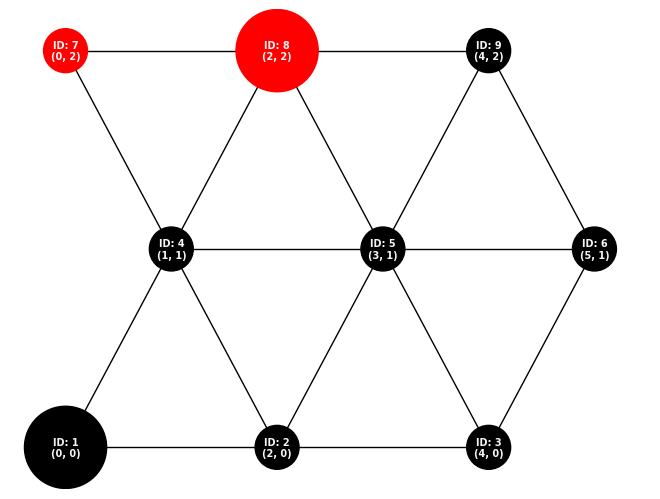

In [12]:
# Customizing network visualization
positions = {}
labels = {}
sizes = []
colors = []
for node in Topology.first().nodes():
    positions[node] = node.coordinates
    labels[node] = f"ID: {node.id}\n{node.coordinates}"
    
    if len(node.base_station.users) > 0:
        sizes.append(3500)
    else:
        sizes.append(1000)
    
    if len(node.base_station.edge_servers) > 0:
        colors.append("red")
    else:
        colors.append("black")

# Drawing the network topology
nx.draw(
    Topology.first(),
    pos=positions,
    node_color=colors,
    node_size=sizes,
    labels=labels,
    font_size=7,
    font_weight="bold",
    font_color="whitesmoke",
)

### Exporting the Dataset

Once we have created our dataset, we can export it to JSON using one of EdgeSimPy's `ComponentManager` helper methods.

Note that EdgeSimPy enables you to define custom attributes for the simulated entities. However, before exporting the dataset, you will need to override the `_to_dict()` method of the modified entities, instructing EdgeSimPy to serialize the objects into JSON.

This aspect of EdgeSimPy's flexibility stems from a well-defined exporting structure, which divides the entity attributes into two groups:
- `attributes`: object attributes that don't reference other simulated entities.
- `relationships`: object attributes that reference other simulated entities.

As long as you respect EdgeSimPy's exporting structure, it will be able to automatically identify any custom attribute/relationship added to the simulated entities.

Please observe that the `_to_dict()` below, which is a simplified version of the one used in the EdgeServer entity. There is a couple of interesting pieces of information to observe in the method.
- **Attributes**:
  - All entity objects must export their object IDs as such attribute is used to distinguish one object from another.
  - Common items within the `"attributes"` key have the following data types: `str`, `int`, `float`, `list`, `tuple`, `bool`, `set`, `NoneType`, and `dict`. In this example, we have an int (`"id"`), a list (`"coordinates"`), and a dict (`"delays"`) attributes. Please notice that dictionaries ("dicts" for short) are stored using Python's `copy.deepcopy()` method to avoid reference errors.
- **Relationships**:
  - This example ships all the common types of relationships:
    - `"mobility_model"`: references a function name.
    - `"base_station"`: points to a single object. Please notice that this type of relationship is encapsulated inside a dictionary with two keys that instruct EdgeSimPy about the referenced object's class and ID.
    - `"applications"`: points to a list of objects. It uses a list with multiple dictionary structures, like in the `"base_station"` attribute, to encapsulate the referenced objects.

```python
class EdgeServer(ComponentManager, Agent):
    
    ...
    
    def _to_dict(self) -> dict:
        access_patterns = {}
        for app_id, access_pattern in self.access_patterns.items():
            access_patterns[app_id] = {"class": access_pattern.__class__.__name__, "id": access_pattern.id}

        dictionary = {
            "attributes": {
                "id": self.id,
                "coordinates": self.coordinates,
                "delays": copy.deepcopy(self.delays),
            },
            "relationships": {
                "mobility_model": self.mobility_model.__name__,
                "base_station": {"class": type(self.base_station).__name__, "id": self.base_station.id},
                "applications": [{"class": type(app).__name__, "id": app.id} for app in self.applications],
            },
        }
        return dictionary
```


As we didn't change any of the simulated entities, we can move on and export our dataset:

In [13]:
dataset = ComponentManager.export_scenario(save_to_file=True, file_name="sample_dataset")

## Running the Simulation

Most EdgeSimPy simulations work around resource management policies executed at each time step that can (optionally) manipulate applications and the underlying infrastructure. As this example focuses on demonstrating power consumption and mobility models, we will create a resource management policy that does not act on the simulated scenario. Instead, it manipulates the edge servers' demand to demonstrate the behavior of the different power consumption models. Please note that directly changing the hosts' demand is not recommended—we are just doing this to show how the power consumption models work based on the varying demand.

In [14]:
def cool_resource_management_policy(parameters: dict):
    current_time_step = parameters["current_step"]
    for edge_server in EdgeServer.all():
        edge_server.cpu_demand = current_time_step


To see EdgeSimPy in action, we need to create an instance of the `Simulator` class, which will manage the simulation for us. There are a couple of parameters passed to the `Simulator` class constructor that we must know to achieve the goal of this notebook:
- `dump_interval`: how often (in terms of simulation time steps) will EdgeSimPy dump logs to the disk.
- `tick_unit`: time unit represented by simulation time steps.
- `tick_duration`: how much time (in the chosen time unit) passes at each time step (e.g., 1 second or 100 milliseconds).
- `stopping_criterion`: boolean expression checked at each time step that stops the simulation as soon as it returns True.
- `resource_management_algorithm`: resource management policy executed at each time step.
- `user_defined_functions`: set of user-defined functions executed during the simulation. This is an important argument for embedding custom models into EdgeSimPy simulations. We must pass a list referencing all the system models (in our case, `MyCustomPowerModel` and `my_custom_mobility_model`) to allow EdgeSimPy to use them during the simulation.

After instantiating the `Simulator` class, we can load our dataset and run the simulation.

In [15]:
# Instantiating the simulator
simulator = Simulator(
    dump_interval=5,
    tick_unit="minutes",
    tick_duration=1,
    stopping_criterion=lambda model: model.schedule.steps == 10,
    resource_management_algorithm=cool_resource_management_policy,
    user_defined_functions=[MyCustomPowerModel, my_custom_mobility_model]
)

# Loading our dataset
simulator.initialize(input_file="datasets/sample_dataset.json")

# Running the simulation
simulator.run_model()

## Analyzing the Simulation Results

EdgeSimPy has a robust monitoring system that can be easily extended and leveraged in various ways. We have an independent notebook detailing EdgeSimPy monitoring capabilities—you can check it out on [this link](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/monitoring-simulation.ipynb).

In this notebook, we will parse the simulator logs (stored in MessagePack format) with Pandas, as this approach can be adopted more readily in various circumstances, including sole simulations and automated batch simulation executions.

### Parsing Simulation Logs

First, let's use a chunk of boilerplate code to format the output of Pandas dataframes:

In [16]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 5000
pd.options.display.max_colwidth = 199
pd.options.display.width = 1000


def highlight_rows(row):
    if row["Time Step"] % 2 == 0:
        return ["background-color: #222222; color: white"] * len(row)
    else:
        return ["background-color: #333333; color: white"] * len(row)

Now, let's read the log files and parse them to Pandas dataframes:

In [17]:
# Gathering the list of msgpack files in the current directory
logs_directory = f"{os.getcwd()}/logs"
dataset_files = [file for file in os.listdir(logs_directory) if ".msgpack" in file]

# Reading msgpack files found
datasets = {}
for file in dataset_files:
    with open(f"logs/{file}", "rb") as data_file:
        datasets[file.replace(".msgpack", "")] = pd.DataFrame(msgpack.unpackb(data_file.read(), strict_map_key=False))

Once we have dataframes hosting our simulation logs, we can check the metrics from the different simulated entities, e.g., edge servers and users.

In [18]:
datasets["EdgeServer"].copy().style.apply(highlight_rows, axis=1)

,Object,Time Step,Instance ID,Coordinates,Available,CPU,RAM,Disk,CPU Demand,RAM Demand,Disk Demand,Ongoing Migrations,Services,Registries,Layers,Images,Download Queue,Waiting Queue,Max. Concurrent Layer Downloads,Power Consumption
0,EdgeServer_1,0,1,"[0, 2]",True,10,4096,102400,0,0,0,0,[],[],[],[],[],[],3,11.000000
1,EdgeServer_2,0,2,"[2, 2]",True,10,4096,102400,0,0,0,0,[],[],[],[],[],[],3,0.000000
2,EdgeServer_1,1,1,"[0, 2]",True,10,4096,102400,1,0,0,0,[],[],[],[],[],[],3,20.900000
3,EdgeServer_2,1,2,"[2, 2]",True,10,4096,102400,1,0,0,0,[],[],[],[],[],[],3,2.000000
4,EdgeServer_1,2,1,"[0, 2]",True,10,4096,102400,2,0,0,0,[],[],[],[],[],[],3,30.800000
5,EdgeServer_2,2,2,"[2, 2]",True,10,4096,102400,2,0,0,0,[],[],[],[],[],[],3,4.000000
6,EdgeServer_1,3,1,"[0, 2]",True,10,4096,102400,3,0,0,0,[],[],[],[],[],[],3,40.700000
7,EdgeServer_2,3,2,"[2, 2]",True,10,4096,102400,3,0,0,0,[],[],[],[],[],[],3,6.000000
8,EdgeServer_1,4,1,"[0, 2]",True,10,4096,102400,4,0,0,0,[],[],[],[],[],[],3,50.600000
9,EdgeServer_2,4,2,"[2, 2]",True,10,4096,102400,4,0,0,0,[],[],[],[],[],[],3,8.000000


In [19]:
datasets["User"].copy().style.apply(highlight_rows, axis=1)

,Object,Time Step,Instance ID,Coordinates,Base Station,Delays,Communication Paths,Making Requests,Access History
0,User_1,0,1,"[0, 0]","BaseStation_1 ([0, 0])",{},{},{},{}
1,User_2,0,2,"[2, 2]","BaseStation_8 ([2, 2])",{},{},{},{}
2,User_1,1,1,"[1, 1]","BaseStation_4 ([1, 1])",{},{},{},{}
3,User_2,1,2,"[2, 2]","BaseStation_8 ([2, 2])",{},{},{},{}
4,User_1,2,1,"[3, 1]","BaseStation_5 ([3, 1])",{},{},{},{}
5,User_2,2,2,"[2, 2]","BaseStation_8 ([2, 2])",{},{},{},{}
6,User_1,3,1,"[5, 1]","BaseStation_6 ([5, 1])",{},{},{},{}
7,User_2,3,2,"[1, 1]","BaseStation_4 ([1, 1])",{},{},{},{}
8,User_1,4,1,"[3, 1]","BaseStation_5 ([3, 1])",{},{},{},{}
9,User_2,4,2,"[1, 1]","BaseStation_4 ([1, 1])",{},{},{},{}


In addition, we can employ Pandas functions to transform the structure of dataframes to get specific pieces of information, such as the user mobility traces and the edge servers' power consumption.

In [20]:
print("=== USER MOBILITY TRACES ===")
users_coordinates = dict(datasets["User"].groupby('Object')['Coordinates'].apply(list))
for user, mobility_logs in users_coordinates.items():
    print(f"{user}. Mobility Logs: {mobility_logs}")

print("\n\n")

print("=== EDGE SERVERS' POWER CONSUMPTION ===")
edge_servers_power_consumption = dict(datasets["EdgeServer"].groupby('Object')['Power Consumption'].apply(list))
for edge_server, power_consumption in edge_servers_power_consumption.items():
    print(f"{edge_server}. Power Consumption per Step: {power_consumption}")

=== USER MOBILITY TRACES ===
User_1. Mobility Logs: [[0, 0], [1, 1], [3, 1], [5, 1], [3, 1], [2, 0], [1, 1], [0, 2], [1, 1], [0, 0], [2, 0]]
User_2. Mobility Logs: [[2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [0, 0], [0, 0], [0, 0], [4, 2], [4, 2]]



=== EDGE SERVERS' POWER CONSUMPTION ===
EdgeServer_1. Power Consumption per Step: [11.0, 20.9, 30.8, 40.7, 50.6, 60.5, 70.4, 80.3, 90.2, 100.1, 110.0]
EdgeServer_2. Power Consumption per Step: [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]


## Next Steps

Although this notebook is reasonably simple, it presents the fundamentals for employing built-in and custom system models on EdgeSimPy simulations. If you are interested in learning more about EdgeSimPy, please check out the other notebooks available:

- [Loading Datasets](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/loading-datasets.ipynb)
- [Manipulating Components](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/manipulating-components.ipynb)
- [Creating a Migration Algorithm](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/creating-migration-algorithm.ipynb)
- [Creating a Placement Algorithm](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/creating-placement-algorithm.ipynb)
- [Monitoring Simulations](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/monitoring-simulation.ipynb)
- [Automating Experiments](https://github.com/EdgeSimPy/edgesimpy-tutorials/blob/master/notebooks/automating-experiments.ipynb)

In addition to testing these notebooks on your local computer, you can execute them without installing dependencies through cloud platforms such as Google Colaboratory. To explore such an option, access our tutorials repository ([link here](https://github.com/EdgeSimPy/edgesimpy-tutorials)) and click on any of the "RUN" options on the side of each notebook.